# Spiking Synchronization Metrics

This tutorial demonstrates advanced spike train analysis functions in `braintools.metric`. We'll cover:

- **Distance Measures**: `victor_purpura_distance`, `van_rossum_distance`
- **Synchrony Indices**: `spike_train_synchrony`, `correlation_index`
- **Advanced Measures**: `spike_time_tiling_coefficient`, `phase_locking_value`, `burst_synchrony_index`

These functions provide sophisticated methods for quantifying spike train similarities, synchronization, and temporal relationships.

In [1]:
import jax.numpy as jnp
import numpy as np
import braintools
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## 1. Spike Train Distance Measures

Distance measures quantify dissimilarity between spike trains and are essential for spike train clustering and classification.

### 1.1 Victor-Purpura Distance

The Victor-Purpura distance measures the minimum cost to transform one spike train into another through insertions, deletions, and temporal shifts.

Victor-Purpura Distance Examples:
Same train: 0.000
Slightly shifted: 5.000
Different pattern: 6.000


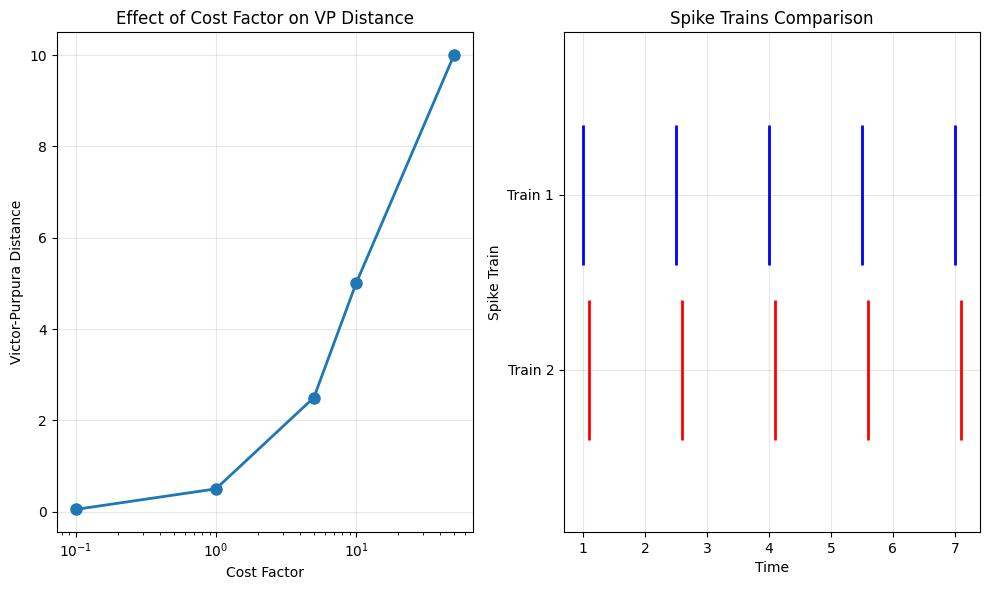

In [2]:
# Create example spike trains
spikes1 = jnp.array([1.0, 2.5, 4.0, 5.5, 7.0])  # Original train
spikes2 = jnp.array([1.1, 2.6, 4.1, 5.6, 7.1])  # Slightly shifted
spikes3 = jnp.array([1.0, 3.0, 6.0])             # Different pattern

print("Victor-Purpura Distance Examples:")
print(f"Same train: {braintools.metric.victor_purpura_distance(spikes1, spikes1):.3f}")
print(f"Slightly shifted: {braintools.metric.victor_purpura_distance(spikes1, spikes2, cost_factor=10.0):.3f}")
print(f"Different pattern: {braintools.metric.victor_purpura_distance(spikes1, spikes3, cost_factor=10.0):.3f}")

# Effect of cost factor
cost_factors = [0.1, 1.0, 5.0, 10.0, 50.0]
distances = []

for cost in cost_factors:
    dist = braintools.metric.victor_purpura_distance(spikes1, spikes2, cost_factor=cost)
    distances.append(dist)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.semilogx(cost_factors, distances, 'o-', linewidth=2, markersize=8)
plt.xlabel('Cost Factor')
plt.ylabel('Victor-Purpura Distance')
plt.title('Effect of Cost Factor on VP Distance')
plt.grid(True, alpha=0.3)

# Visualize the spike trains
plt.subplot(1, 2, 2)
plt.eventplot([spikes1, spikes2], lineoffsets=[1, 0], linelengths=0.8, linewidths=2, colors=['blue', 'red'])
plt.ylabel('Spike Train')
plt.xlabel('Time')
plt.title('Spike Trains Comparison')
plt.yticks([0, 1], ['Train 2', 'Train 1'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.2 van Rossum Distance

The van Rossum distance convolves spike trains with exponential kernels and computes the Euclidean distance between the resulting continuous functions.


van Rossum Distance Examples:
Same train (tau=1.0): 0.000
Shifted train (tau=0.1): 5.763
Shifted train (tau=2.0): 0.353


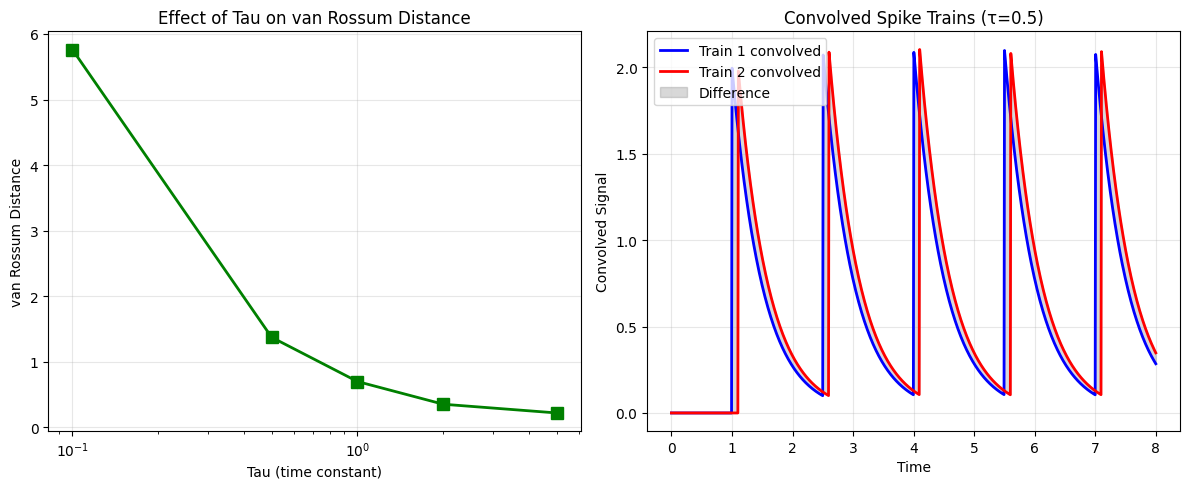

In [3]:
# van Rossum distance with different tau values
tau_values = [0.1, 0.5, 1.0, 2.0, 5.0]
vr_distances = []

for tau in tau_values:
    dist = braintools.metric.van_rossum_distance(spikes1, spikes2, tau=tau)
    vr_distances.append(dist)

print("\nvan Rossum Distance Examples:")
print(f"Same train (tau=1.0): {braintools.metric.van_rossum_distance(spikes1, spikes1, tau=1.0):.3f}")
print(f"Shifted train (tau=0.1): {braintools.metric.van_rossum_distance(spikes1, spikes2, tau=0.1):.3f}")
print(f"Shifted train (tau=2.0): {braintools.metric.van_rossum_distance(spikes1, spikes2, tau=2.0):.3f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogx(tau_values, vr_distances, 's-', linewidth=2, markersize=8, color='green')
plt.xlabel('Tau (time constant)')
plt.ylabel('van Rossum Distance')
plt.title('Effect of Tau on van Rossum Distance')
plt.grid(True, alpha=0.3)

# Show convolved spike trains for visualization
plt.subplot(1, 2, 2)
t = jnp.linspace(0, 8, 1000)
tau_demo = 0.5

# Simple convolution visualization (approximation)
def convolve_demo(spike_times, t, tau):
    signal = jnp.zeros_like(t)
    for spike_time in spike_times:
        kernel = jnp.where(t >= spike_time, 
                          (1/tau) * jnp.exp(-(t - spike_time)/tau), 0)
        signal += kernel
    return signal

conv1 = convolve_demo(spikes1, t, tau_demo)
conv2 = convolve_demo(spikes2, t, tau_demo)

plt.plot(t, conv1, 'b-', linewidth=2, label='Train 1 convolved')
plt.plot(t, conv2, 'r-', linewidth=2, label='Train 2 convolved')
plt.fill_between(t, conv1, conv2, alpha=0.3, color='gray', label='Difference')
plt.xlabel('Time')
plt.ylabel('Convolved Signal')
plt.title(f'Convolved Spike Trains (τ={tau_demo})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Population Synchrony Measures

These measures quantify synchronization across multiple spike trains simultaneously.

### 2.1 Spike Train Synchrony

Measures synchronization by counting coincident events within time windows.


Spike Train Synchrony Results:
High Sync: ['0.356', '0.772', '1.000', '1.000']
Medium Sync: ['0.089', '0.174', '0.276', '0.466']
Low Sync: ['0.057', '0.129', '0.195', '0.384']


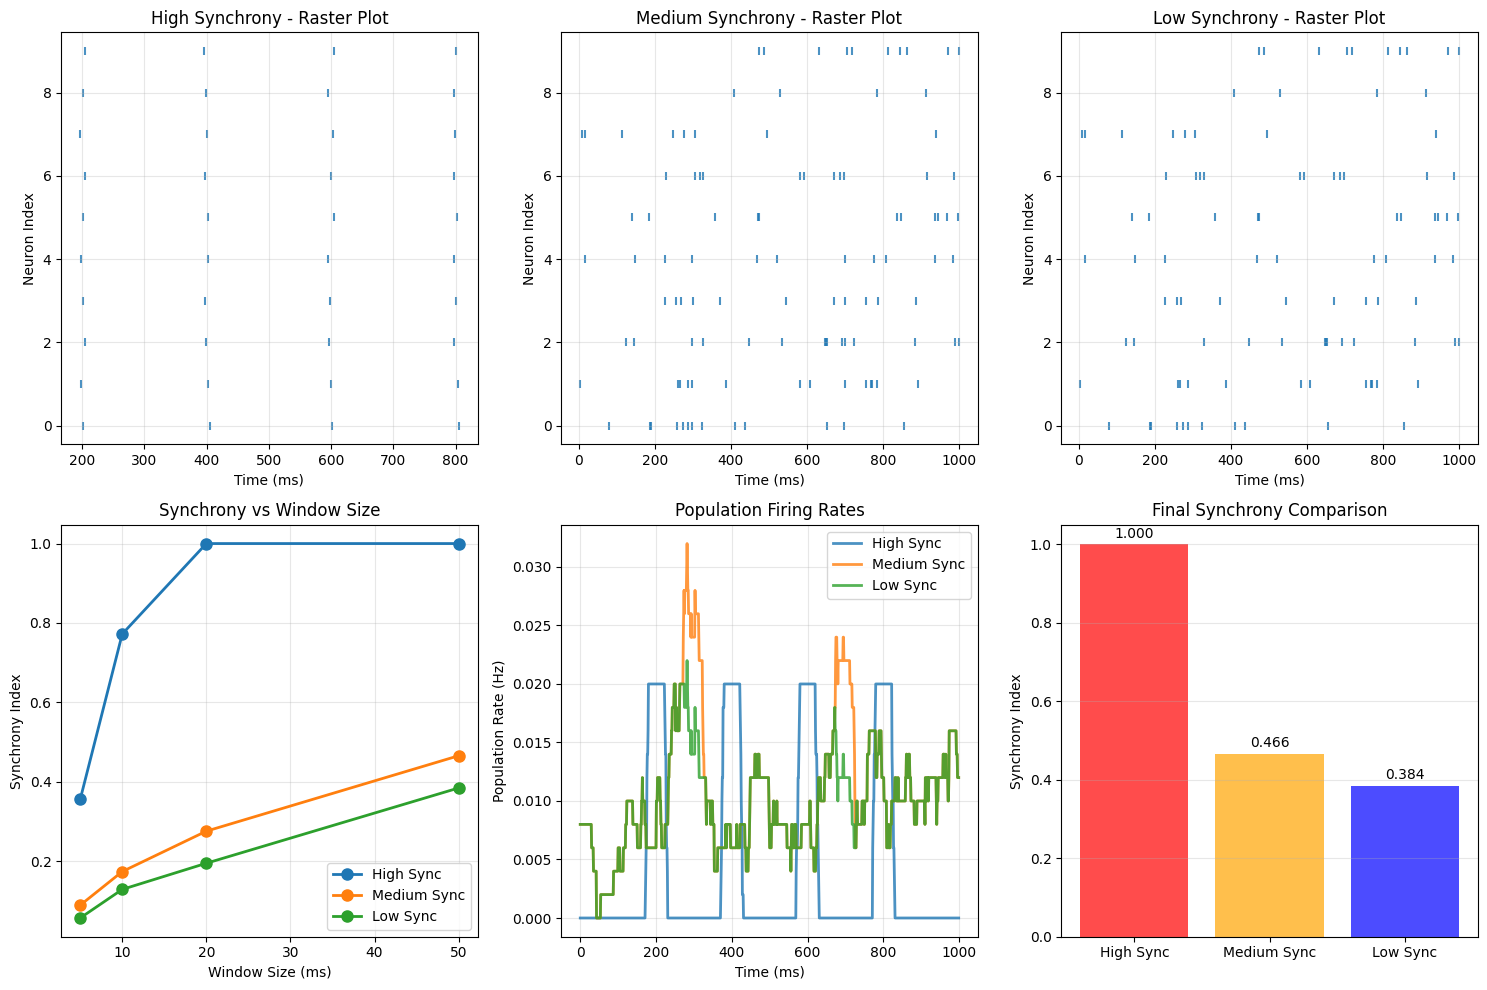

In [4]:
# Generate spike data with different synchrony levels
n_neurons = 10
n_time = 1000
dt = 1.0  # ms

# Scenario 1: High synchrony - synchronized bursts
sync_spikes = jnp.zeros((n_time, n_neurons))
burst_times = [200, 400, 600, 800]
for t in burst_times:
    # Add jitter to make it realistic
    for i in range(n_neurons):
        jitter = np.random.randint(-5, 6)  # ±5ms jitter
        spike_time = max(0, min(n_time-1, t + jitter))
        sync_spikes = sync_spikes.at[spike_time, i].set(1)

# Scenario 2: Low synchrony - random spikes
async_spikes = (np.random.random((n_time, n_neurons)) < 0.01).astype(float)

# Scenario 3: Medium synchrony - some synchronized events + noise
medium_spikes = async_spikes.copy()
for t in [300, 700]:
    for i in range(n_neurons//2):  # Only half the neurons participate
        jitter = np.random.randint(-3, 4)
        spike_time = max(0, min(n_time-1, t + jitter))
        medium_spikes[spike_time, i] = 1

# Calculate synchrony for different window sizes
window_sizes = [5.0, 10.0, 20.0, 50.0]
sync_results = {'High Sync': [], 'Medium Sync': [], 'Low Sync': []}

for window in window_sizes:
    sync_high = braintools.metric.spike_train_synchrony(sync_spikes, window_size=window, dt=dt)
    sync_medium = braintools.metric.spike_train_synchrony(medium_spikes, window_size=window, dt=dt)
    sync_low = braintools.metric.spike_train_synchrony(async_spikes, window_size=window, dt=dt)
    
    sync_results['High Sync'].append(sync_high)
    sync_results['Medium Sync'].append(sync_medium)
    sync_results['Low Sync'].append(sync_low)

print("\nSpike Train Synchrony Results:")
for scenario, values in sync_results.items():
    print(f"{scenario}: {[f'{v:.3f}' for v in values]}")

# Visualize results
plt.figure(figsize=(15, 10))

# Plot spike rasters
for i, (spikes, title) in enumerate([(sync_spikes, 'High Synchrony'), 
                                     (medium_spikes, 'Medium Synchrony'), 
                                     (async_spikes, 'Low Synchrony')]):
    plt.subplot(2, 3, i+1)
    neuron_indices, spike_times = braintools.metric.raster_plot(spikes, jnp.arange(n_time) * dt)
    plt.scatter(spike_times, neuron_indices, marker='|', s=30, alpha=0.8)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron Index')
    plt.title(f'{title} - Raster Plot')
    plt.grid(True, alpha=0.3)

# Plot synchrony vs window size
plt.subplot(2, 3, 4)
for scenario, values in sync_results.items():
    plt.plot(window_sizes, values, 'o-', linewidth=2, markersize=8, label=scenario)
plt.xlabel('Window Size (ms)')
plt.ylabel('Synchrony Index')
plt.title('Synchrony vs Window Size')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot firing rates
plt.subplot(2, 3, 5)
for spikes, label in [(sync_spikes, 'High'), (medium_spikes, 'Medium'), (async_spikes, 'Low')]:
    firing_rate = braintools.metric.firing_rate(spikes, 50.0, dt)
    times = jnp.arange(len(firing_rate)) * dt
    plt.plot(times, firing_rate, linewidth=2, label=f'{label} Sync', alpha=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Population Rate (Hz)')
plt.title('Population Firing Rates')
plt.legend()
plt.grid(True, alpha=0.3)

# Summary comparison
plt.subplot(2, 3, 6)
scenarios = list(sync_results.keys())
final_sync = [values[-1] for values in sync_results.values()]  # Use largest window
colors = ['red', 'orange', 'blue']
bars = plt.bar(scenarios, final_sync, color=colors, alpha=0.7)
plt.ylabel('Synchrony Index')
plt.title('Final Synchrony Comparison')
plt.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, final_sync):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 2.2 Correlation Index

Measures synchrony using Pearson correlations between binned spike counts.


Correlation Index Results:
High Sync: ['0.450', '0.414', '0.340', '0.120']
Medium Sync: ['0.012', '0.017', '0.009', '-0.005']
Low Sync: ['-0.005', '-0.007', '-0.023', '-0.032']


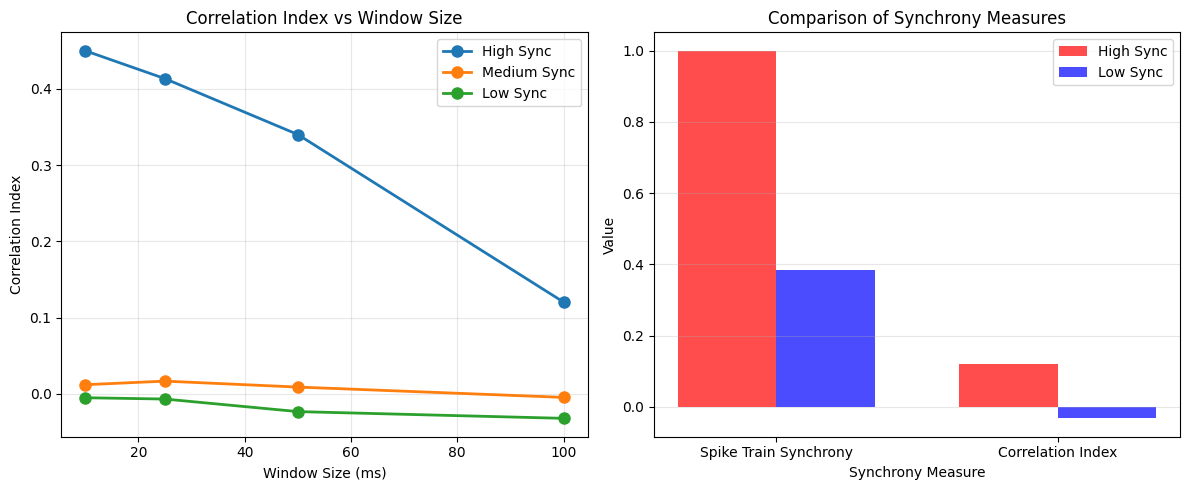

In [5]:
# Calculate correlation index for our spike data
window_sizes_ci = [10.0, 25.0, 50.0, 100.0]
ci_results = {'High Sync': [], 'Medium Sync': [], 'Low Sync': []}

for window in window_sizes_ci:
    ci_high = braintools.metric.correlation_index(sync_spikes, window_size=window, dt=dt)
    ci_medium = braintools.metric.correlation_index(medium_spikes, window_size=window, dt=dt)
    ci_low = braintools.metric.correlation_index(async_spikes, window_size=window, dt=dt)
    
    ci_results['High Sync'].append(ci_high)
    ci_results['Medium Sync'].append(ci_medium)
    ci_results['Low Sync'].append(ci_low)

print("\nCorrelation Index Results:")
for scenario, values in ci_results.items():
    print(f"{scenario}: {[f'{v:.3f}' for v in values]}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for scenario, values in ci_results.items():
    plt.plot(window_sizes_ci, values, 'o-', linewidth=2, markersize=8, label=scenario)
plt.xlabel('Window Size (ms)')
plt.ylabel('Correlation Index')
plt.title('Correlation Index vs Window Size')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare synchrony measures
plt.subplot(1, 2, 2)
sync_measures = ['Spike Train Synchrony', 'Correlation Index']
high_values = [sync_results['High Sync'][-1], ci_results['High Sync'][-1]]
low_values = [sync_results['Low Sync'][-1], ci_results['Low Sync'][-1]]

x = np.arange(len(sync_measures))
width = 0.35

plt.bar(x - width/2, high_values, width, label='High Sync', color='red', alpha=0.7)
plt.bar(x + width/2, low_values, width, label='Low Sync', color='blue', alpha=0.7)

plt.xlabel('Synchrony Measure')
plt.ylabel('Value')
plt.title('Comparison of Synchrony Measures')
plt.xticks(x, sync_measures)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Advanced Synchronization Measures

These measures provide more sophisticated analysis of temporal relationships and specific types of synchronization.

### 3.1 Spike Time Tiling Coefficient (STTC)

STTC controls for firing rate differences when measuring synchrony.


Spike Time Tiling Coefficient Matrix:
Shape: (5, 5)
Diagonal: [1. 1. 1. 1. 1.]
Mean off-diagonal: 0.022

Firing rates: [16. 25. 30. 46. 55.] Hz


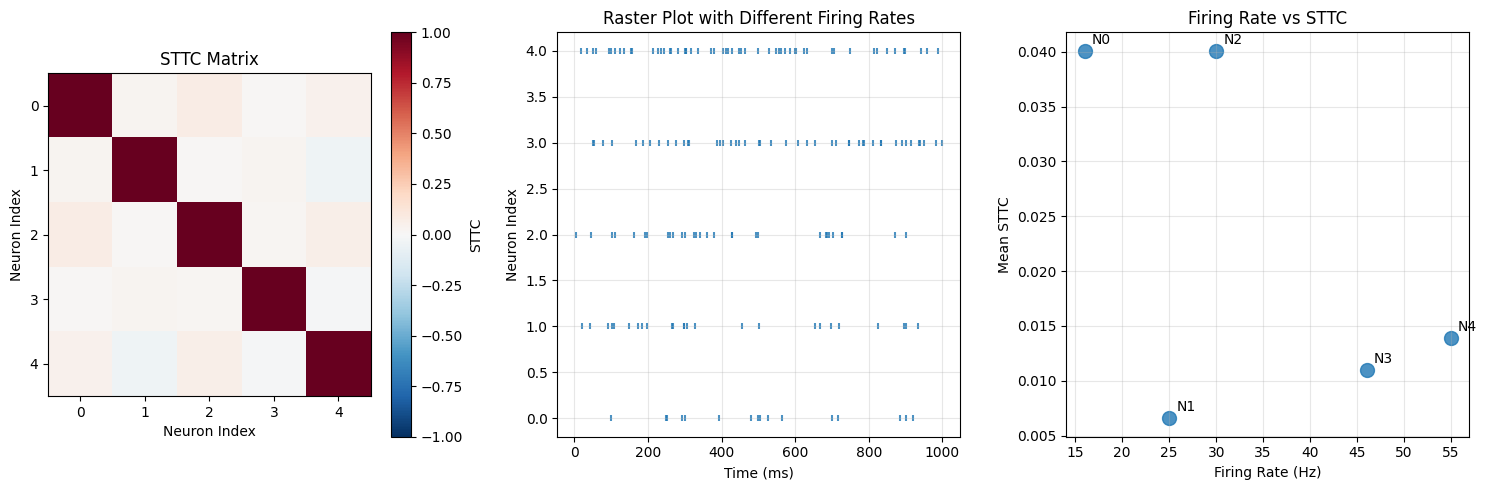

In [6]:
# Create spike data with different firing rates but similar synchrony
n_neurons = 5
spikes_sttc = jnp.zeros((1000, n_neurons))

# Add synchronized events
sync_times = [100, 300, 500, 700, 900]
for t in sync_times:
    for i in range(n_neurons):
        jitter = np.random.randint(-2, 3)
        spike_time = max(0, min(999, t + jitter))
        spikes_sttc = spikes_sttc.at[spike_time, i].set(1)

# Add different amounts of background activity
for i in range(n_neurons):
    # Different firing rates: 1%, 2%, 3%, 4%, 5%
    bg_rate = (i + 1) * 0.01
    bg_spikes = np.random.random(1000) < bg_rate
    spikes_sttc = spikes_sttc.at[:, i].set(jnp.maximum(spikes_sttc[:, i], bg_spikes))

# Calculate STTC matrix
sttc_matrix = braintools.metric.spike_time_tiling_coefficient(spikes_sttc, dt=1.0, tau=0.01)

print("\nSpike Time Tiling Coefficient Matrix:")
print(f"Shape: {sttc_matrix.shape}")
print(f"Diagonal: {jnp.diag(sttc_matrix)}")
print(f"Mean off-diagonal: {jnp.mean(sttc_matrix[jnp.triu_indices_from(sttc_matrix, k=1)]):.3f}")

# Calculate firing rates for each neuron
firing_rates = jnp.sum(spikes_sttc, axis=0) / (1000 * 1e-3)  # Convert to Hz
print(f"\nFiring rates: {firing_rates} Hz")

plt.figure(figsize=(15, 5))

# Plot STTC matrix
plt.subplot(1, 3, 1)
im = plt.imshow(sttc_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, label='STTC')
plt.title('STTC Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')

# Plot raster
plt.subplot(1, 3, 2)
neuron_indices, spike_times = braintools.metric.raster_plot(spikes_sttc, jnp.arange(1000))
plt.scatter(spike_times, neuron_indices, marker='|', s=20, alpha=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Raster Plot with Different Firing Rates')
plt.grid(True, alpha=0.3)

# Plot firing rates vs STTC
plt.subplot(1, 3, 3)
# Extract mean STTC for each neuron (excluding diagonal)
mean_sttc_per_neuron = []
for i in range(n_neurons):
    other_neurons = [j for j in range(n_neurons) if j != i]
    mean_sttc = jnp.mean(sttc_matrix[i, other_neurons])
    mean_sttc_per_neuron.append(mean_sttc)

plt.scatter(firing_rates, mean_sttc_per_neuron, s=100, alpha=0.8)
for i, (fr, sttc) in enumerate(zip(firing_rates, mean_sttc_per_neuron)):
    plt.annotate(f'N{i}', (fr, sttc), xytext=(5, 5), textcoords='offset points')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Mean STTC')
plt.title('Firing Rate vs STTC')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Phase Locking Value (PLV)

PLV measures the consistency of phase relationships between spikes and a reference oscillation.

Phase preferences: [  0.  60. 120. 180. 240. 300.] degrees

Phase Locking Values:
Neuron 0: PLV = 0.590, Preferred phase = 0.0°
Neuron 1: PLV = 0.582, Preferred phase = 60.0°
Neuron 2: PLV = 0.573, Preferred phase = 120.0°
Neuron 3: PLV = 0.685, Preferred phase = 180.0°
Neuron 4: PLV = 0.681, Preferred phase = 240.0°
Neuron 5: PLV = 0.565, Preferred phase = 300.0°


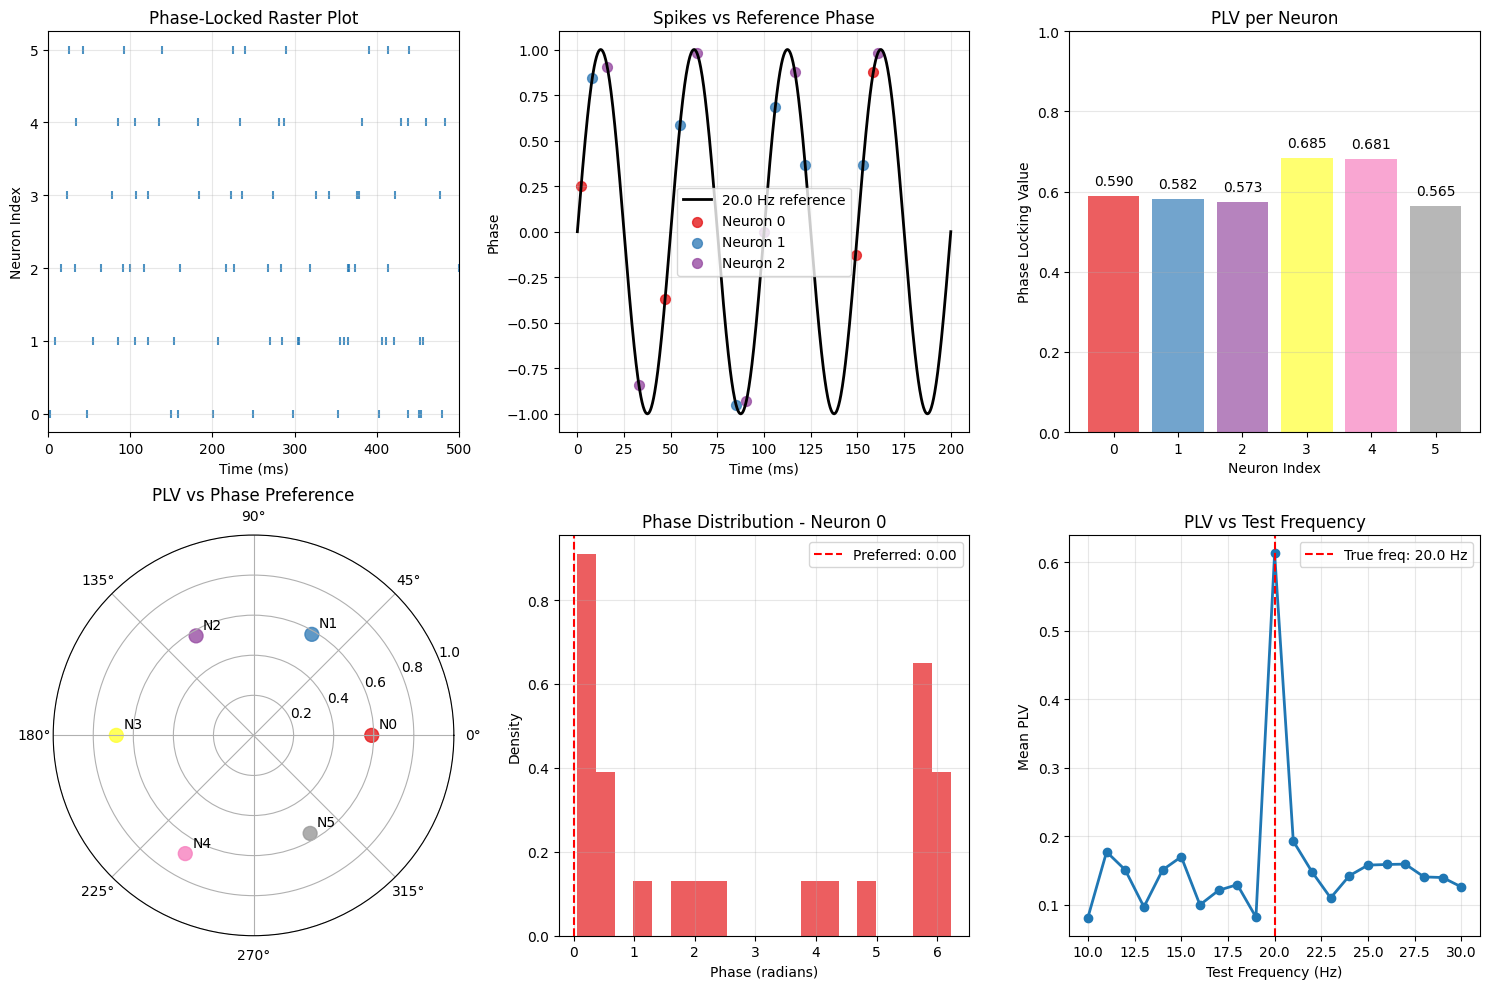

In [7]:
# Generate phase-locked spike data
n_time = 2000
dt = 0.5  # 0.5 ms resolution
freq = 20.0  # 20 Hz reference frequency
n_neurons = 6

spikes_plv = jnp.zeros((n_time, n_neurons))
times = jnp.arange(n_time) * dt / 1000  # Convert to seconds

# Create neurons with different phase preferences
phase_preferences = jnp.linspace(0, 2*jnp.pi, n_neurons, endpoint=False)
print(f"Phase preferences: {phase_preferences * 180 / jnp.pi} degrees")

# Add phase-locked spikes with some jitter
for cycle in range(int(freq * times[-1])):
    cycle_time = cycle / freq
    for i, phase_pref in enumerate(phase_preferences):
        # Time when this neuron should spike (at its preferred phase)
        preferred_time = cycle_time + phase_pref / (2 * jnp.pi * freq)
        
        # Add some jitter and probabilistic spiking
        if np.random.random() < 0.8:  # 80% probability of spiking
            jitter = np.random.normal(0, 0.002)  # 2ms std jitter
            actual_time = preferred_time + jitter
            
            # Convert back to time index
            time_idx = int(actual_time * 1000 / dt)
            if 0 <= time_idx < n_time:
                spikes_plv = spikes_plv.at[time_idx, i].set(1)

# Add some random background spikes
background = (np.random.random((n_time, n_neurons)) < 0.005).astype(float)
spikes_plv = jnp.maximum(spikes_plv, background)

# Calculate PLV
plv_values = braintools.metric.phase_locking_value(spikes_plv, freq, dt / 1000)

print(f"\nPhase Locking Values:")
for i, (plv, phase) in enumerate(zip(plv_values, phase_preferences)):
    print(f"Neuron {i}: PLV = {plv:.3f}, Preferred phase = {phase*180/jnp.pi:.1f}°")

plt.figure(figsize=(15, 10))

# Plot raster with phase information
plt.subplot(2, 3, 1)
neuron_indices, spike_times = braintools.metric.raster_plot(spikes_plv, jnp.arange(n_time) * dt)
plt.scatter(spike_times[:1000], neuron_indices[:1000], marker='|', s=30, alpha=0.8)  # Show first 500ms
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Phase-Locked Raster Plot')
plt.xlim(0, 500)
plt.grid(True, alpha=0.3)

# Plot reference oscillation
plt.subplot(2, 3, 2)
t_ref = jnp.linspace(0, 200, 1000)  # First 200ms
reference_signal = jnp.sin(2 * jnp.pi * freq * t_ref / 1000)
plt.plot(t_ref, reference_signal, 'k-', linewidth=2, label=f'{freq} Hz reference')

# Overlay spike times for first few neurons
colors = plt.cm.Set1(np.linspace(0, 1, n_neurons))
for i in range(min(3, n_neurons)):
    neuron_spikes = spike_times[neuron_indices == i]
    neuron_spikes = neuron_spikes[neuron_spikes <= 200]
    plt.scatter(neuron_spikes, jnp.sin(2 * jnp.pi * freq * neuron_spikes / 1000), 
               color=colors[i], s=50, label=f'Neuron {i}', alpha=0.8)

plt.xlabel('Time (ms)')
plt.ylabel('Phase')
plt.title('Spikes vs Reference Phase')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot PLV values
plt.subplot(2, 3, 3)
bars = plt.bar(range(n_neurons), plv_values, color=colors, alpha=0.7)
plt.xlabel('Neuron Index')
plt.ylabel('Phase Locking Value')
plt.title('PLV per Neuron')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

for bar, plv in zip(bars, plv_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{plv:.3f}', ha='center', va='bottom')

# Polar plot of phase preferences vs PLV
plt.subplot(2, 3, 4, projection='polar')
plt.scatter(phase_preferences, plv_values, c=colors, s=100, alpha=0.8)
for i, (angle, r) in enumerate(zip(phase_preferences, plv_values)):
    plt.annotate(f'N{i}', (angle, r), xytext=(5, 5), textcoords='offset points')
plt.ylim(0, 1)
plt.title('PLV vs Phase Preference')

# Phase histogram for one neuron
plt.subplot(2, 3, 5)
neuron_idx = 0
neuron_spike_times = spike_times[neuron_indices == neuron_idx] / 1000  # Convert to seconds
spike_phases = (2 * jnp.pi * freq * neuron_spike_times) % (2 * jnp.pi)

plt.hist(spike_phases, bins=20, alpha=0.7, density=True, color=colors[neuron_idx])
plt.xlabel('Phase (radians)')
plt.ylabel('Density')
plt.title(f'Phase Distribution - Neuron {neuron_idx}')
plt.axvline(phase_preferences[neuron_idx], color='red', linestyle='--', 
           label=f'Preferred: {phase_preferences[neuron_idx]:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# PLV vs frequency (sensitivity analysis)
plt.subplot(2, 3, 6)
test_freqs = jnp.linspace(10, 30, 21)
plv_vs_freq = []

for test_freq in test_freqs:
    test_plv = braintools.metric.phase_locking_value(spikes_plv, test_freq, dt / 1000)
    plv_vs_freq.append(jnp.mean(test_plv))

plt.plot(test_freqs, plv_vs_freq, 'o-', linewidth=2, markersize=6)
plt.axvline(freq, color='red', linestyle='--', label=f'True freq: {freq} Hz')
plt.xlabel('Test Frequency (Hz)')
plt.ylabel('Mean PLV')
plt.title('PLV vs Test Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Burst Synchrony Index

Identifies and quantifies synchronization of burst events across neurons.

Creating burst patterns:
Burst times: [200, 600, 1000, 1400, 1800] ms
Burst duration: 20 ms
Intra-burst frequency: 100 Hz

Burst Synchrony Index: 0.571


D:\codes\projects\braintools\braintools\metric\_correlation.py:119: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  states = jnp.asarray(jnp.sum(states, axis=2) > 0., dtype=jnp.float_)


Spike Train Synchrony: 0.622
Cross Correlation: 0.372


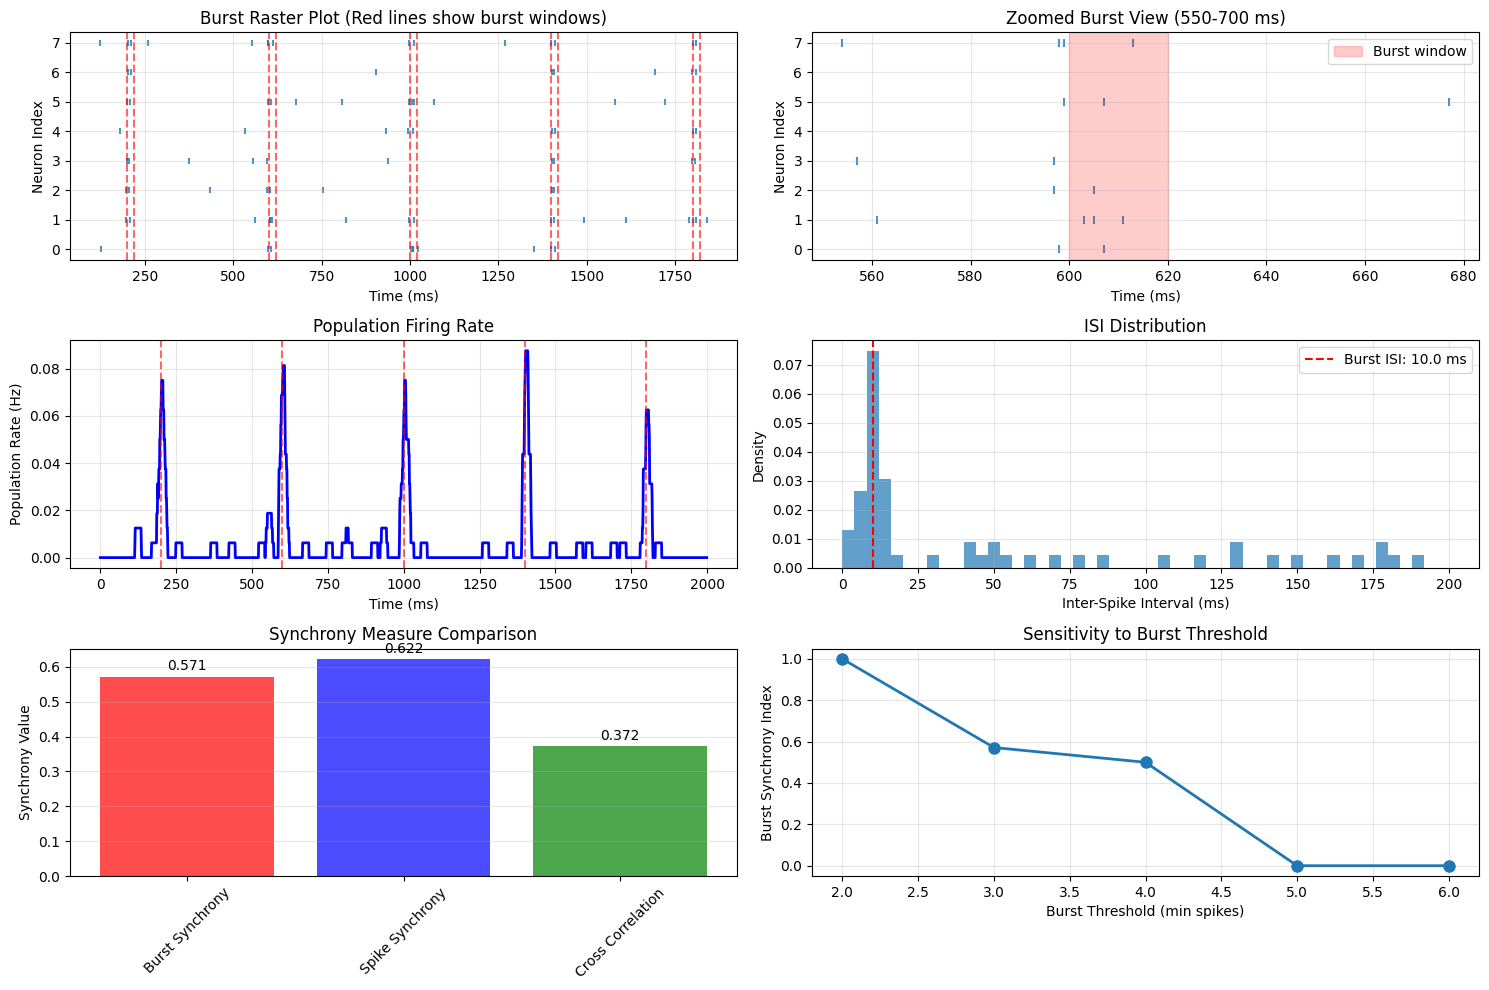

In [8]:
# Generate data with burst patterns
n_time = 2000
n_neurons = 8
dt = 1.0  # ms

spikes_burst = jnp.zeros((n_time, n_neurons))

# Define burst parameters
burst_duration = 20  # ms
burst_frequency = 100  # Hz during burst
burst_times = [200, 600, 1000, 1400, 1800]  # Times when bursts occur

print("Creating burst patterns:")
print(f"Burst times: {burst_times} ms")
print(f"Burst duration: {burst_duration} ms")
print(f"Intra-burst frequency: {burst_frequency} Hz")

# Add synchronized bursts
for burst_start in burst_times:
    for neuron in range(n_neurons):
        # Each neuron participates with some probability
        if np.random.random() < 0.8:  # 80% participation rate
            # Generate burst spikes
            spike_interval = 1000 / burst_frequency  # ms between spikes
            n_spikes = int(burst_duration / spike_interval)
            
            for spike_num in range(n_spikes):
                spike_time = int(burst_start + spike_num * spike_interval + 
                               np.random.normal(0, 2))  # Add jitter
                if 0 <= spike_time < n_time:
                    spikes_burst = spikes_burst.at[spike_time, neuron].set(1)

# Add some isolated spikes (not part of bursts)
isolated_spikes = (np.random.random((n_time, n_neurons)) < 0.002).astype(float)
spikes_burst = jnp.maximum(spikes_burst, isolated_spikes)

# Calculate burst synchrony
burst_sync = braintools.metric.burst_synchrony_index(spikes_burst,
                                                     burst_threshold=3,
                                                     max_isi=50.0,
                                                     dt=dt)

print(f"\nBurst Synchrony Index: {burst_sync:.3f}")

# Also calculate other synchrony measures for comparison
spike_sync = braintools.metric.spike_train_synchrony(spikes_burst, window_size=30.0, dt=dt)
cross_corr = braintools.metric.cross_correlation(spikes_burst, bin=20.0, dt=dt)

print(f"Spike Train Synchrony: {spike_sync:.3f}")
print(f"Cross Correlation: {cross_corr:.3f}")

plt.figure(figsize=(15, 10))

# Full raster plot
plt.subplot(3, 2, 1)
neuron_indices, spike_times = braintools.metric.raster_plot(spikes_burst, jnp.arange(n_time) * dt)
plt.scatter(spike_times, neuron_indices, marker='|', s=20, alpha=0.8)
for t in burst_times:
    plt.axvline(t, color='red', linestyle='--', alpha=0.6)
    plt.axvline(t + burst_duration, color='red', linestyle='--', alpha=0.6)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Burst Raster Plot (Red lines show burst windows)')
plt.grid(True, alpha=0.3)

# Zoomed view of one burst
plt.subplot(3, 2, 2)
zoom_start, zoom_end = burst_times[1] - 50, burst_times[1] + 100
zoom_mask = (spike_times >= zoom_start) & (spike_times <= zoom_end)
plt.scatter(spike_times[zoom_mask], neuron_indices[zoom_mask], marker='|', s=40, alpha=0.8)
plt.axvspan(burst_times[1], burst_times[1] + burst_duration, alpha=0.2, color='red', label='Burst window')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title(f'Zoomed Burst View ({zoom_start}-{zoom_end} ms)')
plt.legend()
plt.grid(True, alpha=0.3)

# Population firing rate
plt.subplot(3, 2, 3)
pop_rate = braintools.metric.firing_rate(spikes_burst, 20.0, dt)
rate_times = jnp.arange(len(pop_rate)) * dt
plt.plot(rate_times, pop_rate, linewidth=2, color='blue')
for t in burst_times:
    plt.axvline(t, color='red', linestyle='--', alpha=0.6)
plt.xlabel('Time (ms)')
plt.ylabel('Population Rate (Hz)')
plt.title('Population Firing Rate')
plt.grid(True, alpha=0.3)

# Inter-spike interval distribution
plt.subplot(3, 2, 4)
all_isis = []
for neuron in range(n_neurons):
    neuron_spikes = spike_times[neuron_indices == neuron]
    if len(neuron_spikes) > 1:
        isis = jnp.diff(neuron_spikes)
        all_isis.extend(isis)

plt.hist(all_isis, bins=50, alpha=0.7, density=True, range=(0, 200))
plt.axvline(1000/burst_frequency, color='red', linestyle='--', 
           label=f'Burst ISI: {1000/burst_frequency:.1f} ms')
plt.xlabel('Inter-Spike Interval (ms)')
plt.ylabel('Density')
plt.title('ISI Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Synchrony comparison
plt.subplot(3, 2, 5)
measures = ['Burst Synchrony', 'Spike Synchrony', 'Cross Correlation']
values = [burst_sync, spike_sync, cross_corr]
colors = ['red', 'blue', 'green']

bars = plt.bar(measures, values, color=colors, alpha=0.7)
plt.ylabel('Synchrony Value')
plt.title('Synchrony Measure Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# Burst detection sensitivity
plt.subplot(3, 2, 6)
burst_thresholds = [2, 3, 4, 5, 6]
burst_sync_vs_threshold = []

for threshold in burst_thresholds:
    bs = braintools.metric.burst_synchrony_index(spikes_burst,
                                                 burst_threshold=threshold,
                                                 max_isi=50.0, dt=dt)
    burst_sync_vs_threshold.append(bs)

plt.plot(burst_thresholds, burst_sync_vs_threshold, 'o-', linewidth=2, markersize=8)
plt.xlabel('Burst Threshold (min spikes)')
plt.ylabel('Burst Synchrony Index')
plt.title('Sensitivity to Burst Threshold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Comparison

1. When to Use Each Measure:

**Distance Measures:**
- **Victor-Purpura Distance**: Spike train clustering, template matching, cost-based dissimilarity
- **van Rossum Distance**: Temporal smoothing important, rate-based coding

**Synchrony Measures:**
- **Spike Train Synchrony**: Simple coincidence detection, event-based synchrony
- **Correlation Index**: Rate-based synchrony, bin-size effects important
- **Cross-correlation**: Population-level synchrony, binning approach

**Advanced Measures:**
- **STTC**: Rate-independent synchrony, controls for firing rate differences
- **Phase Locking Value**: Rhythmic synchronization, oscillatory coupling
- **Burst Synchrony Index**: Burst-based activity, epileptic-like patterns

2. Parameter Guidelines:

- **Window sizes**: 5-50ms for fast synchrony, 50-200ms for slower dynamics
- **Cost factors (VP)**: 1-10 for temporal precision, >10 for strict timing
- **Tau (van Rossum)**: 0.1-1ms for precise timing, 1-10ms for rate coding
- **Burst thresholds**: 3-5 spikes typical, adjust based on firing rates

3. Best Practices:

1. **Multiple measures**: Use several measures to capture different aspects
2. **Parameter sensitivity**: Test multiple parameter values
3. **Statistical validation**: Use surrogate data and significance testing
4. **Biological relevance**: Choose measures appropriate for your system
5. **Computational efficiency**: Consider trade-offs for large datasets